In [3]:
from __future__ import print_function

from astroquery.vizier import Vizier
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Problem 3

This notebook solves problem 3 in the third problem set. We are here asked to do a PCA analysis of the fundamental plane of galaxies.

## 3a) Load the table(s)

We want the SMAC. III. Fundamental Plane catalog from Hudson et al (2001). Let us try to find this.

In [24]:
catalog_list = Vizier.find_catalogs('SMAC. III. Fundamental Plane')

In [5]:
for k,v in catalog_list.items():
    print("{0}: {1}".format(k, v.description))


J/MNRAS/327/249: SMAC. II. Fundamental Plane photometric data (Smith+, 2001)
J/MNRAS/327/265: SMAC. III. Fundamental Plane catalog (Hudson+, 2001)


So we clearly need the second one. But we need the full table

In [8]:
wanted = list(catalog_list.keys())[1]
print("I will load {0}".format(wanted))

I will load J/MNRAS/327/265


In [42]:
# This ensures we get the whole catalog
# See https://github.com/astropy/astroquery/issues/917
v = Vizier(columns=["**"], catalog=wanted, row_limit=-1)
res = v.query_constraints(row_limit=-1)
catalogs = v.get_catalogs(wanted)
#        catalogs = Vizier(columns=["**"], catalog=wanted, row_limit=-1).query_constraints()
#
#catalogs = Vizier.get_catalogs(wanted, columns='all')

In [43]:
len(catalogs)

2

ah, so we got two catalogues. That is fine. What we want is the second one given the information in the problem set.

In [44]:
catalog = catalogs[1]

## 3 b)

*The relevant columns are `logRe` ($\log R_e$), `__mu_e` ($\log \mu_e$) and logsigma ($\log \sigma$). There are
many parametrisations of the fundamental plane. For concreteness we choose the one from
Jørgensen, Franx \& Kjærgard (1996, MNRAS, 280, 167): 
$$\log R_e = 1.24 \log \sigma - 0.82 log I_e + \mathrm{constant}$$.

Does your data fit this relation? What is scatter in log re around this plane? [recall that
$\mu_e = -2.5 \log I_e$]. All log's are to the base 10.*

This basically asks us to plot the data and then to calculate the rms around this best fit. So let us for clarity define the relation as a function:

In [45]:
logsigma = catalog['logsigma']
logRe = catalog['logRe']
mu_e = catalog['__mu_e']

In [46]:
def jfk_plane(logsigma, mu_e, offset=0.0):
    """Return the Jørgensen, Franx & Kjærgard (1996) fundamental plane"""
    
    logIe = -mu_e/2.5
    
    logRe = 1.24*logsigma - 0.82*logIe + offset
    
    return logRe

In [47]:
logRe_nonorm = jfk_plane(logsigma, mu_e)

First let us just plot the data and visually see that they lie on a straight line. I also make a fit to the line using LinearRegression.

In [61]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
res = model.fit(logRe_nonorm.reshape(-1, 1), logRe)

xplot = np.linspace(8, 10.5, 20)
logRe_lin = model.predict(xplot.reshape(-1, 1))

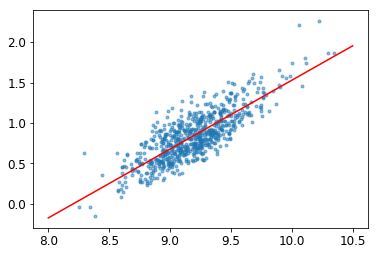

In [62]:
plt.scatter(logRe_nonorm, logRe, marker='.', alpha=0.5)
plt.plot(xplot, logRe_lin, color='red')

So that is a decent fit. We can now get the best offset as well and calculate the scatter around the line.

In [65]:
best_offset = model.intercept_
print("The best offset={0:.3f}".format(best_offset))

The best offset=-6.985


In [67]:
scatter = np.std(logRe_nonorm-logRe)
print("The scatter around the model is {0:.3f}".format(scatter))

The scatter around the model is 0.185


## 3 c)

*c) Carry out a PCA of these data. Which eigenvector should you choose to define the plane (recall that
a plane is defined up to a constant by its normal vector).? Does your PCA solution match the one from
Jørgensen et al? Calculate the spread in re around this plane - is it smaller or larger than the one found
using the Jørgensen parametrisation?*

So to do this it is worth thinking a bit and the logic here is that a logical way to define a plane is to think about 